In [1]:
import os
from glob import glob

# Install necessary libraries if you don't have them
# !pip install torch ipywidgets matplotlib
import ipywidgets as widgets
from ipywidgets import interact_manual
import matplotlib.pyplot as plt
import numpy as np
import torch

from datasets.fmri_dataloader import DataModule

# Ensure plots are displayed inline in Jupyter
%matplotlib inline
print("Libraries imported successfully.")

Libraries imported successfully.


# Helper function to visualize fMRI data

In [2]:
def visualize_tensor_slice(data, b, w, t, cmap='viridis', with_background_mask=False):
    """
    Visualizes a 2D slice (D, W) of the 5D tensor at a specific
    batch (b), width (w), and time step (t).

    Args:
        data (torch.Tensor or np.ndarray): The 5D tensor (B, D, H, W, T).
        b (int): Batch index.
        w (int): Width index.
        t (int): Time step index.
    """
    # Check if data is a torch tensor and convert to numpy if necessary
    if isinstance(data, torch.Tensor):
        # Ensure tensor is on CPU before converting to numpy
        if data.device != torch.device('cpu'):
             plot_data = data.cpu().numpy()
             print("Tensor moved from GPU to CPU for plotting.")
        else:
             plot_data = data.numpy()
    elif isinstance(data, np.ndarray):
        plot_data = data
        
    # Validate indices
    shape = plot_data.shape
    # Select the 2D slice (D, H)
    try:
        slice_dh = plot_data[b, :, :, w, t]
    except IndexError as e:
         print(f"Error slicing data with indices b={b}, w={w}, t={t}: {e}")
         return

    # --- Plotting ---
    if not with_background_mask:
        fig, ax = plt.subplots(figsize=(7, 6)) # Adjust figure size as needed
    
        # Use imshow to display the 2D slice
        im = ax.imshow(slice_dh, cmap=cmap, origin='lower', interpolation='nearest',
                      vmin=plot_data.min((1,2,3,4))[b], vmax=plot_data.max((1,2,3,4))[b])
    
        # Add titles and labels
        ax.set_title(f'Spatial Slice (D x H)\nBatch={b}, Width={w}, Time={t}')
        ax.set_xlabel(f'Depth (x-axis, Size: {shape[1]})')
        ax.set_ylabel(f'Height (y-axis, Size: {shape[2]})')
    
        # Add a colorbar to indicate values
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Tensor Value')
    else:
        fig, axes = plt.subplots(ncols=2, figsize=(12, 6)) # Adjust figure size as needed

        ax = axes[0]
        # Use imshow to display the 2D slice
        im = ax.imshow(slice_dh, cmap=cmap, origin='lower', interpolation='nearest',
                      vmin=plot_data.min((1,2,3,4))[b], vmax=plot_data.max((1,2,3,4))[b])
    
        # Add titles and labels
        ax.set_title(f'Spatial Slice (D x H)\nBatch={b}, Width={w}, Time={t}')
        ax.set_xlabel(f'Depth (x-axis, Size: {shape[1]})')
        ax.set_ylabel(f'Height (y-axis, Size: {shape[2]})')
    
        # Add a colorbar to indicate values
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Tensor Value')

        # draw brain/background plot
        values, counts = np.unique(slice_dh, return_counts=True)
        background_value = values[np.argmax(counts)]
        mask_ax = axes[-1]
        mask_slice = (slice_dh==background_value)
        im2 = mask_ax.imshow(mask_slice, cmap=cmap, origin='lower', interpolation='nearest',
                             vmin=mask_slice.min(), vmax=mask_slice.max())
        # Add titles and labels
        mask_ax.set_title(f'Brain & Background (value={background_value:.2f})')
        mask_ax.set_xlabel(f'Depth (x-axis, Size: {shape[1]})')
        mask_ax.set_ylabel(f'Height (y-axis, Size: {shape[2]})')

    # Show the plot
    plt.tight_layout() # Adjust layout to prevent overlapping labels
    plt.show()

In [3]:
def create_interactive_plot(tensor_data, cmap='viridis', with_background_mask=False):
    B, D, H, W, T = tensor_data.shape
    b_slider = widgets.IntSlider(min=0, max=max(0, B-1), step=1, value=0, description='Batch (B):')
    w_slider = widgets.IntSlider(min=0, max=max(0, W-1), step=1, value=0, description='Width (H):')
    t_slider = widgets.IntSlider(min=0, max=max(0, T-1), step=1, value=0, description='Time (T):')

    # Use interact_manual to create controls and a button to trigger the visualization
    # Pass the tensor data as a fixed argument
    interactive_plot = interact_manual(
        lambda b, w, t: visualize_tensor_slice(tensor_data, b, w, t, cmap, with_background_mask),
        b=b_slider,
        w=w_slider,
        t=t_slider
    )
    return interactive_plot

# Load fMRI data and visualize

In [4]:
data_module = DataModule('./cfgs/hcp_data_all_config.yaml')

In [5]:
data_module.setup()
train_loader = data_module.train_dataloader()
test_loader = data_module.val_dataloader()

Loading cached subject dictionary from data/subj_dict/S1200_age_HCP_filtered_run1_MNI_to_TRs.pickle
Loading splits from ./data/splits/S1200_split2.pkl
Randomly sampling 400 of 863 subjects.
Generating dataset list from scratch...
Number of subjects for S1200 'train': 400
Randomly sampling 50 of 107 subjects.
Loading cached dataset list from data/data_tuple/age_HCP_filtered_run1_MNI_to_TRs_val_seqlen2_within1_between1.0.csv
Cache is stale (subject mismatch). Regenerating...
Generating dataset list from scratch...
Number of subjects for S1200 'val': 50
Randomly sampling 50 of 109 subjects.
Loading cached dataset list from data/data_tuple/age_HCP_filtered_run1_MNI_to_TRs_test_seqlen2_within1_between1.0.csv
Cache is stale (subject mismatch). Regenerating...
Generating dataset list from scratch...
Number of subjects for S1200 'test': 50

Total training segments: 4800
Total validation segments: 600
Total test segments: 600


In [6]:
for batch in test_loader:
    fmri, subj, target_value, tr, sex = batch.values()
    break

/pscratch/sd/t/tbalasoo/MAMBAINR/trans-inr-master/datasets/fmri_datasets.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_frames = [torch.load(os.path.join(subjec

In [7]:
print(fmri.shape)
print(subj)
print(tr)

torch.Size([8, 1, 96, 96, 96, 2])
['545345', '545345', '545345', '545345', '545345', '545345', '545345', '545345']
tensor([ 0,  2,  4,  6,  8, 10, 12, 14])


In [8]:
example_data = fmri[0,...]
example_data.shape

torch.Size([1, 96, 96, 96, 2])

In [11]:
create_interactive_plot(example_data, cmap='gray')

interactive(children=(IntSlider(value=0, description='Batch (B):', max=0), IntSlider(value=0, description='Wid…

<function __main__.create_interactive_plot.<locals>.<lambda>(b, w, t)>

# View the histogram

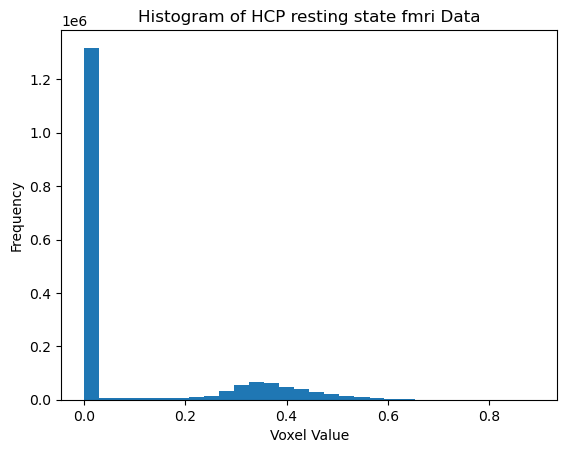

In [10]:
# Extract the data and flatten it
data = example_data.flatten()

# Plot the histogram
plt.hist(data, bins=30)  # Adjust bins as needed
plt.title('Histogram of HCP resting state fmri Data')
plt.xlabel('Voxel Value')
plt.ylabel('Frequency')
plt.show()